# 10 Extras: Sequence Models and Transformers

Additional references: 
- [Character Level Language Model (GPU required)](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/Character_Level_Language_Model_rendered.ipynb)
- [Transformers (BERT fine-tuning): Joint Intent Classification and Slot Filling](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/Transformers_Joint_Intent_Classification_Slot_Filling_rendered.ipynb)
- [Generating Language with huggingface](https://huggingface.co/blog/how-to-generate)
- [huggingface examples](https://huggingface.co/transformers/quickstart.html)

In [1]:
import warnings
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Load data from a pickle file (assuming it's a Pandas DataFrame)
df = pd.read_pickle('sc_cases_cleaned.pkl', compression='gzip')
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 819
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   case_name       768 non-null    object        
 1   opinion_type    768 non-null    object        
 2   date_standard   768 non-null    datetime64[ns]
 3   authorship      768 non-null    object        
 4   x_republican    768 non-null    float64       
 5   maj_judges      768 non-null    object        
 6   dissent_judges  768 non-null    object        
 7   topic_id        768 non-null    float64       
 8   cite_count      768 non-null    float64       
 9   opinion_text    768 non-null    object        
 10  year            768 non-null    int64         
 11  log_cite_count  768 non-null    float64       
 12  preprocessed    768 non-null    object        
 13  author_id       768 non-null    int8          
dtypes: datetime64[ns](1), float64(4), int64(1), int8(1), objec

# Entity Embeddings

In [2]:
# Encode the 'author_id' column using LabelEncoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
J = encoder.fit_transform(df['author_id'].astype(str))
num_judges = max(J) + 1

# Define the target variables Y and Y2
Y = (df['x_republican'] > 0).astype(int)
Y2 = df['log_cite_count']

In [3]:
J[:10]

array([ 3, 10,  5,  4,  4,  9,  1,  3,  2,  3])

In [4]:
# Define a PyTorch model
class NeuralNetwork(nn.Module):
    def __init__(self, num_judges):
        super(NeuralNetwork, self).__init__()
        self.embedding = nn.Embedding(num_judges, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [5]:
# Initiate the model
model = NeuralNetwork(num_judges)

# Define the loss function and optimizer
loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters())

# Print the PyTorch model summary
for name, layer in model.named_children():
    print(name, layer)

/home/cmarangon/anaconda3/envs/nlp_env_newsp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


embedding Embedding(11, 2)
flatten Flatten(start_dim=1, end_dim=-1)
fc1 Linear(in_features=2, out_features=2, bias=True)
fc2 Linear(in_features=2, out_features=1, bias=True)
sigmoid Sigmoid()


In [6]:
X = torch.tensor(J, dtype=torch.long)
Y_torch = torch.tensor(Y.to_numpy(), dtype=torch.float32)

In [7]:
# Convert data to PyTorch tensors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy

X_train, X_test, y_train, y_test = train_test_split(X, Y_torch, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



# create objects for logging
history_val_loss = []
history_train_loss = []
history_val_acc = []
history_train_acc = []

# hold the best model
best_loss = np.inf   # init to infinity
best_weights = None
best_epoch = 0

# set main parameters for training
n_epochs = 50
batch_size = 32

for epoch in range(n_epochs):
    
    for i in range(0, len(X_train), batch_size):
        # take a batch
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        # forward pass
        y_pred = model(X_batch)
        y_batch = y_batch.unsqueeze(1)
        loss = loss_function(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

    # evaluate model at end of each epoch
    model.eval()
    
    y_pred_train_probs = model(X_train)
    y_pred_train = torch.where(y_pred_train_probs > 0.5, 1, 0)

    y_pred_val_probs = model(X_val)
    y_pred_val = torch.where(y_pred_val_probs > 0.5, 1, 0)
    
    y_train_unsq = y_train.unsqueeze(1)
    loss_train = loss_function(y_pred_train_probs, y_train_unsq)
    loss_train = float(loss_train)
    history_train_loss.append(loss_train)
    acc_train = accuracy_score(y_pred_train, y_train)
    history_train_acc.append(acc_train)

    y_val_unsq = y_val.unsqueeze(1)
    loss_val = loss_function(y_pred_val_probs, y_val_unsq)
    loss_val = float(loss_val)
    history_val_loss.append(loss_val)
    acc_val = accuracy_score(y_pred_val, y_val)
    history_val_acc.append(acc_val)

    if loss_val < best_loss:
        best_loss = loss_val
        best_epoch = epoch
        best_weights = copy.deepcopy(model.state_dict())

    # print some information
    if epoch % 10 == 0:
        print(f'Finished epoch {epoch}:')
        print(f'---- Training loss: {np.round(loss_train, 2)}, validation loss: {np.round(loss_val, 2)}')
        print(f'---- Training accuracy: {np.round(acc_train, 2)}, validation accuracy: {np.round(acc_val, 2)}')

Finished epoch 0:
---- Training loss: 0.58, validation loss: 0.57
---- Training accuracy: 0.77, validation accuracy: 0.81
Finished epoch 10:
---- Training loss: 0.45, validation loss: 0.43
---- Training accuracy: 0.77, validation accuracy: 0.81
Finished epoch 20:
---- Training loss: 0.23, validation loss: 0.23
---- Training accuracy: 1.0, validation accuracy: 1.0
Finished epoch 30:
---- Training loss: 0.08, validation loss: 0.09
---- Training accuracy: 1.0, validation accuracy: 1.0
Finished epoch 40:
---- Training loss: 0.03, validation loss: 0.04
---- Training accuracy: 1.0, validation accuracy: 1.0


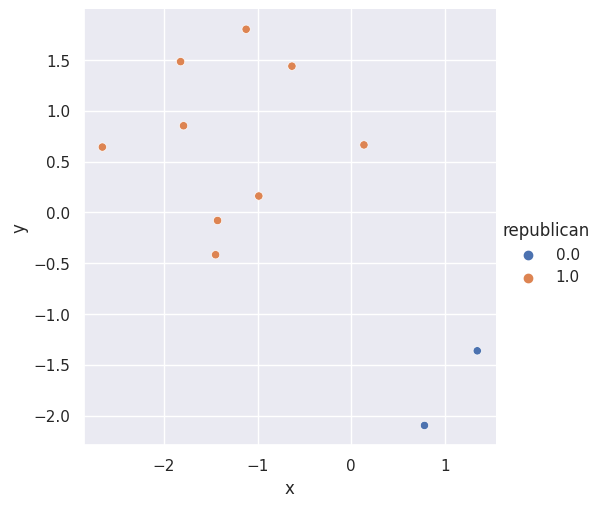

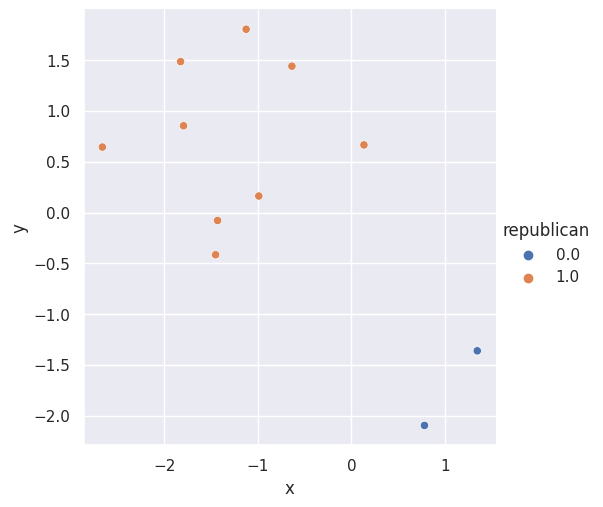

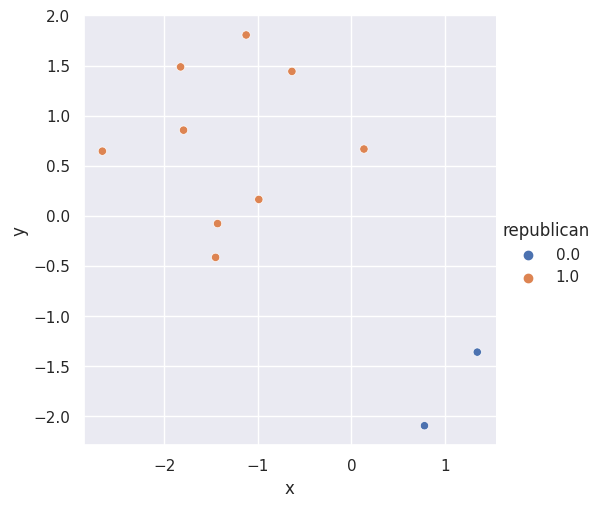

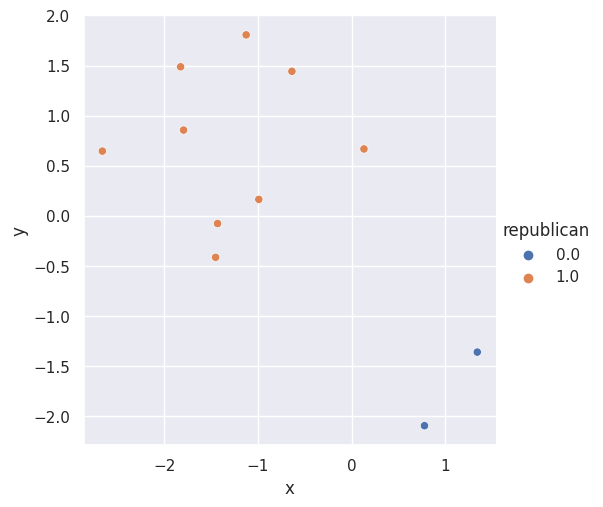

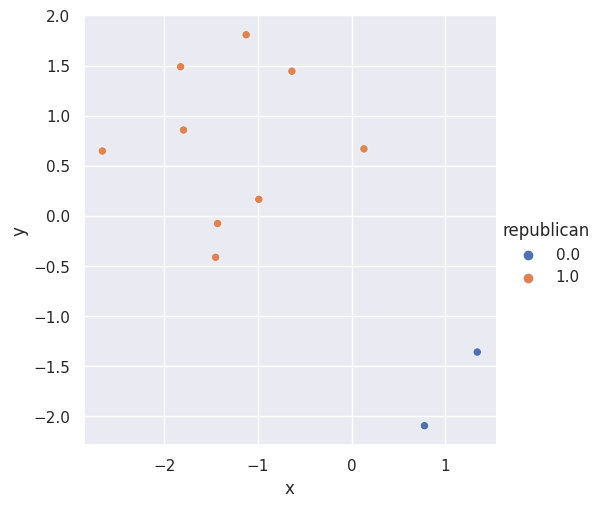

In [8]:
#Visualize the judge vectors
import seaborn as sns
sns.set_theme()

judge_cites = dict(Y2.groupby(J).mean())
rep = dict(Y.groupby(J).mean())
df2 = pd.DataFrame(J,columns=['authorship']).drop_duplicates().sort_values('authorship')
df2['cites'] = df2['authorship'].apply(lambda x: judge_cites[x])
df2['republican'] = df2['authorship'].apply(lambda x: rep[x])

#define new optimizer and loss function
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001)

# Training loop
for i in range(5):
    if i > 0:
        for epoch in range(1):
            model.train()
            judge_vec = torch.tensor(J)
            Y2_torch = torch.tensor(Y2, dtype=torch.float32).reshape(-1, 1)
            optimizer.zero_grad()
            output = model(judge_vec)
            loss = loss_function(output, Y2_torch)
            loss.backward()
            optimizer.step()
    
    # Judge vectors (assuming 'model' contains the embedding layer)
    embedding_weights = model.embedding.weight.data.numpy()
    df2['x'] = embedding_weights[:, 0]
    df2['y'] = embedding_weights[:, 1]
    
    # Visualization
    sns.relplot(data=df2, x="x", y="y", hue='republican', kind='scatter')

# Huggingface Transformer

In [9]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# gpu or cpu?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cpu


Load the model from a pretrained checkpoint. 

In [10]:
model_name = 'distilbert-base-uncased' # huggingface model_ID or path to folder 
model = DistilBertForSequenceClassification.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
inputs = tokenizer(df.iloc[0]['opinion_text'], return_tensors="pt")
#[32, 100, 23, 0, 0, 0, 0, 0] -> [1, 1, 1, 0, 0, 0, 0, 0]

Token indices sequence length is longer than the specified maximum sequence length for this model (4669 > 512). Running this sequence through the model will result in indexing errors


In [12]:
inputs = tokenizer(df['opinion_text'].tolist(), return_tensors="pt", padding=True, truncation=True)
labels = torch.tensor(df['x_republican'].tolist()).long() 
print(inputs, labels)

{'input_ids': tensor([[  101,  3425, 18353,  ...,  6525,  3089,   102],
        [  101,  3425,  8799,  ...,  4781,  2580,   102],
        [  101,  3425,  1051,  ..., 13931,  9964,   102],
        ...,
        [  101,  3425,  8040,  ...,  2005,  1996,   102],
        [  101,  3425,  2726,  ...,  2015,  2006,   102],
        [  101,  3425,  1051,  ..., 25394, 11461,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])} tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1

More infos about huggingface tokenizers can be found [here](https://huggingface.co/transformers/main_classes/tokenizer.html).

Now we have a set of text inputs and authors indicators as labels and we can train a transformers model using a cross-entropy loss function

In [13]:
unique_labels, counts = np.unique(df["x_republican"], return_counts=True)
print (unique_labels, counts)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))

optimizer = torch.optim.Adam([
    {'params': model.distilbert.parameters(), 'lr': 1e-5},  
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])


[0. 1.] [174 594]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['opinion_text'].tolist(), df['x_republican'].tolist(), test_size=.2)

# generate batches
X_train, X_test, y_train, y_test = np.array(X_train[:608]), np.array(X_test[:152]), np.array(y_train[:608]), np.array(y_test[:152])
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test, y_train, y_test = X_train.reshape(-1, 8), X_test.reshape(-1, 8), y_train.reshape(-1, 8), y_test.reshape(-1, 8)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test = X_train.tolist(), X_test.tolist()

(608,) (152,) (608,) (152,)
(76, 8) (19, 8) (76, 8) (19, 8)


In [15]:
# train
from tqdm import tqdm

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for text, labels in tqdm(zip(X_train, y_train), total=len(X_train)):
        # prepare model input through our tokenizer
        model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        # place everything on the right device
        model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
        # labels have to be torch long tensors
        labels = torch.tensor(labels).long()
        # now, we can perform the forward pass
        output = model(**model_inputs, labels=labels)
        loss, logits = output[:2]
        # and the backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


100%|██████████| 76/76 [05:24<00:00,  4.27s/it]


In [16]:
predictions, targets = [], []
model.eval()


with torch.no_grad():
    for text, labels in tqdm(zip(X_test, y_test), total=len(X_test)):
        model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        model_inputs = {k:v.to(device) for k,v in model_inputs.items()}

        output = model(**model_inputs)
        logits = output[0]
        # prediction is the argmax of the logits
        predictions.extend(logits.argmax(dim=1).tolist())
        targets.extend(labels)
        
from sklearn import metrics
accuracy = metrics.accuracy_score(targets, predictions)
print ("accuracy", accuracy)
classification_report = metrics.classification_report(targets, predictions)
print (classification_report)

100%|██████████| 19/19 [00:48<00:00,  2.56s/it]

accuracy 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        27
         1.0       1.00      1.00      1.00       125

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152



So far, we considered the pytorch version for transformers. It also works with keras, a more in-depth tutorial can be found [here](https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a).

In [17]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf

# note that we use TFDistilBert... instead of DistilBert...

transformer_model = TFDistilBertForSequenceClassification.from_pretrained(model_name)

# define model input layer

input_ids = tf.keras.layers.Input(shape=(256,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(256,), name='masked_token', dtype='int32')
X = transformer_model(input_ids, input_masks_ids)
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

2023-10-31 20:17:33.626499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 20:17:34.675056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-31 20:17:34.675075: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-31 20:17:35.929498: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_token[0][0]',            
 assification (TFDistilBertForS  rOutput(loss=None,               'masked_token[0][0]']           
 equenceClassification)         logits=(None, 2),                                                 
                                 hidden_states=None                                           

In [19]:
model.compile(loss='sparse_categorical_crossentropy', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=['accuracy']) # compute accuracy, for scoring


In [20]:
# tokenize X_train
X_train, X_test, y_train, y_test = train_test_split(df['opinion_text'].tolist(), df['x_republican'].tolist(), test_size=.2)
X_train_tf = [tokenizer(x, return_tensors="tf", padding=True, truncation=True, max_length=256) for x in X_train]

In [21]:
input_ids, input_masks = [x["input_ids"][0].numpy() for x in X_train_tf], [x["attention_mask"][0].numpy() for x in X_train_tf]

dataset = tf.data.Dataset.from_tensor_slices(({'input_token': input_ids, 'masked_token': input_masks}, y_train)).batch(8)


In [22]:
model_info = model.fit(dataset,epochs=1)

2023-10-31 20:18:11.416991: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 93763584 exceeds 10% of free system memory.


: 

# Deep Learning - Extra Content

During backpropagation the algorithm computes the gradient of the cost function w.r.t each parameter and it uses these gradients to update each parameter with a Gradient Descent step. <br>

<b>Vanishing gradient problem:</b> gradients often get smaller and smaller as the algorithm progresses down to the lower layers $\implies$ lower layers connection weights remain virtually unchanged. <br>

<b>Exploding gradient problem:</b> gradients grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges.

![attachment:image.png](https://files.codingninjas.in/article_images/vanishing-and-exploding-gradients-0-1644853457.webp)

### Initializers

**Problems:**

- Initial weights too large $\implies$ Exploding Gradient
- Initial weights too small $\implies$ Vanishing Gradient
- Correlated (collinear) initial weights $\implies$ Backpropagation cannot distinguish their contribution to the output error

**Solution:** Initialization of neuron weights should be random *but* you can choose the distribution (standard practice is to use "Glorot" and "HeNormal", which alleviate the problem of unstable gradients).

In [ ]:
from sklearn.datasets import fetch_california_housing
raw_data = fetch_california_housing()

In [ ]:
# re-load the housing data
df = pd.DataFrame(raw_data.data, columns=raw_data['feature_names'])
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
# re-load the housing data
df = pd.DataFrame(raw_data.data, columns=raw_data['feature_names'])
df.head(5)

In [ ]:
X, y = df.iloc[:,:], raw_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# before bulding the model we will transform all our data to tensors
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, X):
      super().__init__()
      # define all the components of the NN
      self.linear1 = nn.Linear(in_features=X.shape[1], out_features=50)
      torch.nn.init.xavier_uniform_(self.linear1.weight) # Glorot initialization! 
      self.act1 = nn.ReLU() 
      self.linear2 = nn.Linear(in_features=50, out_features=1)
      self.act2 = nn.Sigmoid()

    # define how to transform the input
    def forward(self, X):
        X = self.act1(self.linear1(X))
        output = self.act2(self.linear2(X))
        return output

In [ ]:
# initialize the model
model = MyNeuralNetwork(X_train)

In [ ]:
# inspect the initialized weigths
model.linear1.weight[0]

tensor([-0.3165,  0.0996, -0.3036,  0.0872,  0.0322, -0.1303, -0.1353, -0.0381],
       grad_fn=<SelectBackward0>)

In [ ]:
# can our model handle our data?
random_results = model.forward(X_train)
random_results.shape

torch.Size([16512, 1])

### Batch Normalization

**Problem:** Distribution of weights is likely to change at every step of backpropagation $\implies$ slower and less efficient model.

**Solution:** after each layer normalize the inputs to have mean zero and variance 1. It helps to increase performance, speed up training, and regularize the model.

In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, X):
      super().__init__()
      # define all the components of the NN
      self.linear1 = nn.Linear(in_features=X.shape[1], out_features=50)
      torch.nn.init.xavier_uniform_(self.linear1.weight) # Glorot initialization!
      self.normalize1 = nn.BatchNorm1d(50)   # apply batch normalization
      self.act1 = nn.ReLU()
      self.linear2 = nn.Linear(in_features=50, out_features=1)
      self.act2 = nn.Sigmoid()

    # define how to transform the input
    def forward(self, X):
        X = self.act1(self.linear1(X))
        X_normalized = self.normalize1(X)
        output = self.act2(self.linear2(X_normalized))
        return output

In [ ]:
# initialize the model
model = MyNeuralNetwork(X_train)

# can our model handle our data?
random_results = model.forward(X_train)
random_results.shape

torch.Size([16512, 1])

### Alternative Activation Functions

![attachment:image.png](https://www.researchgate.net/profile/Alberto-Marchisio/publication/328878703/figure/fig2/AS:691988286423047@1541994272922/Behavior-of-ReLU-ELU-and-SELU-activation-functions.ppm)

Exponential Linear Unit (ELU) and Scaled ELU (SELU). In particular, SELU enhances the performance of the network, that is a neural network with only dense layers, each using SELU as activation function, the network will self-normalize, provided that:
- inputs are standardized
- it uses LeCun normal initialization for weights
- set $\lambda \approx 1.0507$ and $\alpha \approx 1.6732$
- in general SELU > ELU > ReLU

Note that with SELU batch normalization is not needed as the newtwork self-normalizes

In [ ]:
nn.ELU(alpha=1)
nn.SELU()

SELU()

### Optimizer 

Existing research showed that it has a big impact on the performance of the model. <i>Adam</i> (adaptive moment estimation) is faster and almost as good as <i>sgd</i>. But there are multiple options available.

In [ ]:
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_adam = optim.Adam(model.parameters(), lr=0.0001)
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.0001)

### Regularization and Dropout

Neural network parameters, like regressions, can be regularized with L1 and/or L2 penalties to push weak neurons to zero and create a sparse model $\rightarrow$ avoid overfitting.

In PyTorch, a simple way to add regularization is through the weight decay parameter of the optimizer.

In [ ]:
optimizer_adam = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) 

Alternatively, use <i>dropout</i> during training (it is NOT used during validation), with probability ($p$) between 10% and 50%. Alternative dropout regularizations are:
- Normal dropout: neurons don't get dropped but coefficients are down-weighted by $p$
- Monte Carlo dropout: continues to allow dropout but produce 100 predictions, and averages them

In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, X):
      super().__init__()
      self.linear1 = nn.Linear(in_features=X.shape[1], out_features=50)
      torch.nn.init.xavier_uniform_(self.linear1.weight) # Glorot initialization
      self.normalize1 = nn.BatchNorm1d(50)   # apply batch normalization
      self.dropout1 = nn.Dropout(p=0.3)
      self.act1 = nn.ReLU()
      self.linear2 = nn.Linear(in_features=50, out_features=1)
      self.act2 = nn.Sigmoid()

    def forward(self, X):
        X = self.act1(self.linear1(X))
        X_normalized = self.normalize1(X)
        X = self.dropout1(X)
        output = self.act2(self.linear2(X_normalized))
        return output

In [ ]:
# can our model handle our data?
random_results = model.forward(X_train)
random_results.shape

torch.Size([16512, 1])

## Tuning NN Hyperparameters

It is an active area of research. One option is to try combinations of hyperparameters and see which one works best on the validation set, using GridSearchCV or RandomizedSearchCV

In [ ]:
# install first
# pip install skorch
from skorch import NeuralNet

In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, X, n_neurons):
      super().__init__()
      self.linear1 = nn.Linear(in_features=X.shape[1], out_features=n_neurons)
      torch.nn.init.xavier_uniform_(self.linear1.weight) # Glorot initialization
      self.normalize1 = nn.BatchNorm1d(n_neurons)   # apply batch normalization
      self.dropout1 = nn.Dropout(p=0.3)
      self.act1 = nn.ReLU()
      self.linear2 = nn.Linear(in_features=n_neurons, out_features=1)
      self.act2 = nn.Sigmoid()

    def forward(self, X):
        X = self.act1(self.linear1(X))
        X_normalized = self.normalize1(X)
        X = self.dropout1(X)
        output = self.act2(self.linear2(X_normalized))
        return output

In [ ]:
# create the skorch wrapper
model = NeuralNet(
    module=MyNeuralNetwork(X_train, n_neurons=50),  # neural network architecture
    criterion=nn.MSELoss()   # loss function
)

In [ ]:
print(model.initialize())

<class 'skorch.net.NeuralNet'>[initialized](
  module_=MyNeuralNetwork(
    (linear1): Linear(in_features=8, out_features=50, bias=True)
    (normalize1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (act1): ReLU()
    (linear2): Linear(in_features=50, out_features=1, bias=True)
    (act2): Sigmoid()
  ),
)


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    "module__X": [X_train],
    'module__n_neurons': [10, 50, 100],
}

gs = GridSearchCV(model, params, refit=False, cv=3, scoring='neg_mean_squared_error', verbose=1)
gs

GridSearchCV(cv=3,
             estimator=<class 'skorch.net.NeuralNet'>[initialized](
  module_=MyNeuralNetwork(
    (linear1): Linear(in_features=8, out_features=50, bias=True)
    (normalize1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (act1): ReLU()
    (linear2): Linear(in_features=50, out_features=1, bias=True)
    (...
        [   3.8125,   49.0000,    4.4735,  ...,    1.7381,   33.7700,
         -118.1600],
        [   4.1563,    4.0000,    5.6458,  ...,    2.7232,   34.6600,
         -120.4800],
        ...,
        [   2.9344,   36.0000,    3.9867,  ...,    3.3321,   34.0300,
         -118.3800],
        [   5.7192,   15.0000,    6.3953,  ...,    3.1789,   37.5800,
         -121.9600],
        [   2.5755,   52.0000,    3.4026,  ...,    2.1087,   37.7700,
         -122.4200]])],
                         'module__n_neurons': [10, 50, 100]},
             refit=False, scoring='neg_mean_squared_error', verbose=1)

In [ ]:
gs.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.6349        3.2197  0.4013
      2        3.1818        2.8635  0.3041
      3        2.8984        2.6600  0.1426
      4        2.7422        2.5507  0.1282
      5        2.6575        2.4902  0.1454
      6        2.6092        2.4544  0.1296
      7        2.5797        2.4318  0.1426
      8        2.5605        2.4166  0.1229
      9        2.5473        2.4058  0.1199
     10        2.5378        2.3980  0.1448
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.4852        3.2605  0.1246
      2        3.1555        2.9988  0.1271
      3        2.9414        2.8330  0.1126
      4        2.8049        2.7292  0.1198
      5        2.7189        2.6639  0.1304
      6        2.6645        2.6217  0.1181
      7        2.6289        2.5936  0.1351
      8        

GridSearchCV(cv=3,
             estimator=<class 'skorch.net.NeuralNet'>[initialized](
  module_=MyNeuralNetwork(
    (linear1): Linear(in_features=8, out_features=50, bias=True)
    (normalize1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (act1): ReLU()
    (linear2): Linear(in_features=50, out_features=1, bias=True)
    (...
        [   3.8125,   49.0000,    4.4735,  ...,    1.7381,   33.7700,
         -118.1600],
        [   4.1563,    4.0000,    5.6458,  ...,    2.7232,   34.6600,
         -120.4800],
        ...,
        [   2.9344,   36.0000,    3.9867,  ...,    3.3321,   34.0300,
         -118.3800],
        [   5.7192,   15.0000,    6.3953,  ...,    3.1789,   37.5800,
         -121.9600],
        [   2.5755,   52.0000,    3.4026,  ...,    2.1087,   37.7700,
         -122.4200]])],
                         'module__n_neurons': [10, 50, 100]},
             refit=False, scoring='neg_mean_squared_error', verbose=1)

In [ ]:
gs.best_score_

-2.492409865061442

In [ ]:
gs.best_params_

{'lr': 0.02,
 'max_epochs': 20,
 'module__X': tensor([[   3.2596,   33.0000,    5.0177,  ...,    3.6918,   32.7100,
          -117.0300],
         [   3.8125,   49.0000,    4.4735,  ...,    1.7381,   33.7700,
          -118.1600],
         [   4.1563,    4.0000,    5.6458,  ...,    2.7232,   34.6600,
          -120.4800],
         ...,
         [   2.9344,   36.0000,    3.9867,  ...,    3.3321,   34.0300,
          -118.3800],
         [   5.7192,   15.0000,    6.3953,  ...,    3.1789,   37.5800,
          -121.9600],
         [   2.5755,   52.0000,    3.4026,  ...,    2.1087,   37.7700,
          -122.4200]]),
 'module__n_neurons': 10}

In [ ]:
param_distribs = {
    "lr": reciprocal(3e-4, 3e-2),
    "module__n_neurons": np.arange(1, 100),
    "module__X": [X_train]
}

rnd_search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_distribs, n_iter=10, 
                                   refit=False, scoring='neg_mean_squared_error', verbose=1)
rnd_search_cv

RandomizedSearchCV(estimator=<class 'skorch.net.NeuralNet'>[initialized](
  module_=MyNeuralNetwork(
    (linear1): Linear(in_features=8, out_features=50, bias=True)
    (normalize1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (act1): ReLU()
    (linear2): Linear(in_features=50, out_features=1, bias=True)...
                                        'module__n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   refit=False, scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rnd_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.2990        2.9619  0.2194
      2        2.7902        2.7093  0.1960
      3        2.6150        2.5878  0.2318


      4        2.5505        2.5479  0.1769
      5        2.5213        2.5256  0.1901
      6        2.5060        2.5122  0.1726
      7        2.4962        2.5060  0.1540
      8        2.4899        2.5005  0.1437
      9        2.4855        2.4999  0.1716
     10        2.4823        2.4954  0.1524
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.3076        3.0800  0.1736
      2        2.8353        2.8517  0.1568
      3        2.6654        2.7767  0.1512
      4        2.5980        2.7102  0.1768
      5        2.5650        2.6418  0.1670
      6        2.5420        2.6234  0.1638
      7        2.5276        2.6108  0.1691
      8        2.5163        2.5998  0.2092
      9        2.5079        2.5950  0.1683
     10        2.4990        2.5908  0.1742
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.3041        3.0485  0.1457
      2        2.8076        2.8

RandomizedSearchCV(estimator=<class 'skorch.net.NeuralNet'>[initialized](
  module_=MyNeuralNetwork(
    (linear1): Linear(in_features=8, out_features=50, bias=True)
    (normalize1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (act1): ReLU()
    (linear2): Linear(in_features=50, out_features=1, bias=True)...
                                        'module__n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   refit=False, scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rnd_search_cv.best_params_

{'lr': 0.016097753230597586,
 'module__X': tensor([[   3.2596,   33.0000,    5.0177,  ...,    3.6918,   32.7100,
          -117.0300],
         [   3.8125,   49.0000,    4.4735,  ...,    1.7381,   33.7700,
          -118.1600],
         [   4.1563,    4.0000,    5.6458,  ...,    2.7232,   34.6600,
          -120.4800],
         ...,
         [   2.9344,   36.0000,    3.9867,  ...,    3.3321,   34.0300,
          -118.3800],
         [   5.7192,   15.0000,    6.3953,  ...,    3.1789,   37.5800,
          -121.9600],
         [   2.5755,   52.0000,    3.4026,  ...,    2.1087,   37.7700,
          -122.4200]]),
 'module__n_neurons': 69}

However, this approach is quite time consuming, thus, allows you to test only a few combinations of hyperparameters. Some suggestions:
- It is better to have too many layers, and use regularization
- Try between 1 and 5 layers
- Adding layers usually helps more than adding neurons
- Using ReLU in hidden layers is a good baseline